#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
  w_ = np.array(w)
  score = (X.dot(w_) + w0) * -y
  loss = np.log(1 + np.exp(score))
  return np.sum(loss) / X.shape[0] + gamma * np.sum(np.abs(w_)) + beta * np.sum(w_ ** 2)

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    w_ = np.array(w)
    y_score_product = y * (X.dot(w_) + w0)
    temp_val = y / (1 + np.exp(y_score_product))
    grad_weights = -(1 / X.shape[0]) * X.T.dot(temp_val) + gamma * np.sign(w_) + 2 * beta * w_

    return grad_weights.tolist(),  -(1 / X.shape[0]) * np.sum(temp_val)

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.h = []


    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.w = np.random.randn(X.shape[1])
        self.w0 = np.random.randn()

        for _ in range(self.max_iter):
            current_loss = loss(X, y, self.w, self.w0, gamma=self.gamma, beta=self.beta)
            self.h.append(current_loss)
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, gamma=self.gamma, beta=self.beta)
            grad_w = np.array(grad_w)
            w_new = self.w - self.lr * grad_w
            w0_new = self.w0 - self.lr * grad_w0
            if np.linalg.norm(w_new - self.w) < self.tolerance and abs(w0_new - self.w0) < self.tolerance:
                break
            self.w = w_new
            self.w0 = w0_new


    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)


    def predict_proba(self, X):
        s = X.dot(self.w) + self.w0
        proba = 1 / (1 + np.exp(-s))
        return np.vstack([1 - proba, proba]).T

In [ ]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [ ]:
def plot_decision_boundary(model, X, y):
    x_min_bound, x_max_bound = X[:, 0].min() - 1., X[:, 0].max() + 1.
    y_min_bound, y_max_bound = X[:, 1].min() - 1., X[:, 1].max() + 1.
    step = 0.01

    grid_x, grid_y = np.meshgrid(np.arange(x_min_bound, x_max_bound, step),
                                 np.arange(y_min_bound, y_max_bound, step))

    grid_coordinates = np.c_[grid_x.ravel(), grid_y.ravel()]
    predictions = model.predict(grid_coordinates)
    predictions = predictions.reshape(grid_x.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(grid_x, grid_y, predictions, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')
    plt.show()

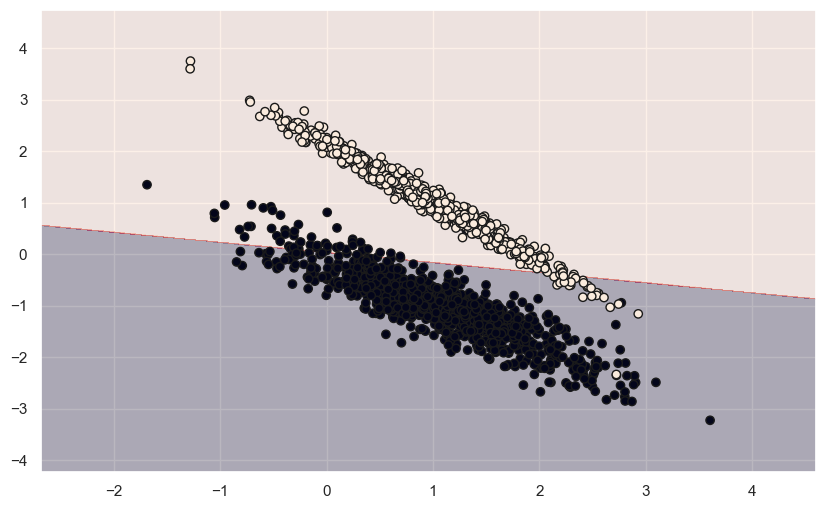

In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

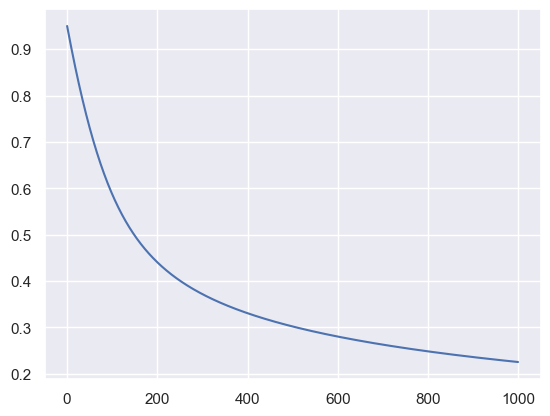

In [ ]:
plt.plot(model.h, label='Loss')

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

Так как у нас SGD все же имеет random_state - прямая разбивающая точки будет рисоваться тоже случайно, но проходить через скопление.

#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.
KNN, k=1, если совсем читерить - я бы взял полный датасет(тогда задача это буквально if if if), и получу 100% acc, но попробую сделать без такого.

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler


dataset = pd.read_csv('train.csv')


train_set = dataset.iloc[:50000]
test_set = dataset.iloc[50000:]

X_train = train_set.drop(['Category', 'Id'], axis=1).values
y_train = train_set['Category'].values

X_test = test_set.drop(['Category', 'Id'], axis=1).values
y_test = test_set['Category'].values


knn = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy on test data: {accuracy:.4f}')

Accuracy on test data: 0.8548


In [ ]:
dataset = pd.read_csv('train.csv')


train_set = dataset
test_set = dataset.iloc[50000:]

X_train = train_set.drop(['Category', 'Id'], axis=1).values
y_train = train_set['Category'].values

X_test = test_set.drop(['Category', 'Id'], axis=1).values
y_test = test_set['Category'].values


knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy on test data: {accuracy:.4f}')

Accuracy on test data: 1.0000


есть люди которые даже статьи на кегле пишут на эту тему. Забавно.